# [Keras - Time-Series Anomaly Detection](https://keras.io/examples/timeseries/timeseries_anomaly_detection/)

In [1]:
# Hiding tensorflow warnings. 
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Numerical arrays.
import numpy as np

# Spreadsheet like dataframes.
import pandas as pd

# Neural networks.
from tensorflow import keras

# layers pf neural networks.
from tensorflow.keras import layers

# Plotting
from matplotlib import pyplot as plt


In [2]:
# Setting plot style.
plt.style.use('bmh')

***

# Introduction

Introduce this notebook, set context for what the reader can expect.

***

# TensorFlow & Keras

### TensorFlow

Tensorflow is a machine learning libary that is used in a variety of programming languages, although Python is the most common language that it is used on. It was created by Google Brain - Google's Machine Intelligence Research organisation in 2012[1]. It was made available for the public in 2015 [2]. Tensorflow uses various tools and libraries to perform various tasks focused on training neural networks [3].

<br>

### What is a neural network?
A neural network or artifical neural network is a form of machine learning. The name and structure was influence by the human brain.  Their structure consist of nodes, and signals. The network contains an input layer of nodes, an output layer, and many hidden layers inbetween. Each node has a weight and treshold.  If the nodes output is above the treshold, the node will send data to the following layer in the network.  Initially training data is read into the neural network. These neural networks become more accurate over time [4]. 

<br>

![neuralnetwork](https://ml-cheatsheet.readthedocs.io/en/latest/_images/neural_network_w_matrices.png)


<br>

### Keras
Keras is a Python library that is embedded into TensorFlow. The Keras library in TensorFlow is used to make the working with neural networks easy as there is a great deal of abtraction. A neural network can be trained in a few lines of code [5]. As eluded to above, the layers are the building blocks of a neural network. The Keras package contains a library of "layers" to be used when building a model.  The mathamatical formulas for these methods are abstracted from the user [6]. More will be discussed on layers later. 




***

<br>

# Time-Series Anomaly Detection.

Anomalies in time-series data are outlier data points which do not conform with the patterns in a sequence of data points collected over an interval of time [7].  Anomaly detection will help segregate outliers.   Below is an example plot showing an outlier in what would otherwise be a linear value-time dataset. 

In [3]:
# x and y values for a line. 
x = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
y = [0,1,2,3,4,5,5,7,8,9,10,11,12,13,14,15,16,17,18]

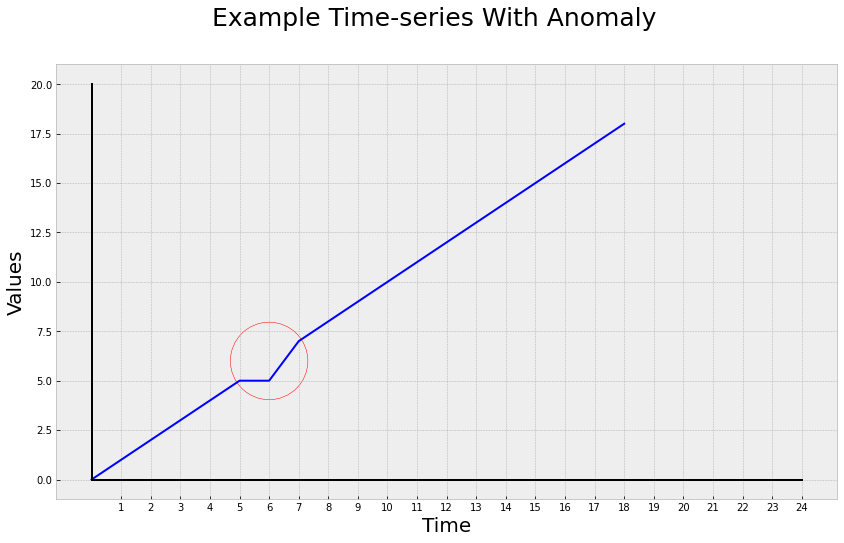

In [4]:
# fig with size 14,8.
fig, ax = plt.subplots(figsize =(14,8))

# plot x and y values
ax.plot(x,y, c='b')

# plot anomaly marker. 
ax.scatter(6,6, marker = 'o', s = 6000, facecolors='none', edgecolors='r')

# Plot better axis. 
ax.plot([0, 24], [0, 0], 'k-')
ax.plot([0, 0], [0, 20], 'k-')

# Plot tick labels.
labels = np.arange (1,25)
ax.set_xticks(labels)
ax.set_xticklabels(labels)

# Setting title. 
fig.suptitle('Example Time-series With Anomaly', fontsize=25)

# Setting x and y axis label. 
plt.xlabel('Time', fontsize=20)
plt.ylabel('Values',fontsize=20);

***

# Keras Time-Series Anomaly Detection.

Keras demonstrates a time-series anomaly detection use case on for their neural network autoencoder on their [webiste](https://keras.io/examples/timeseries/timeseries_anomaly_detection/). This demonstration uses a two datasets from **Numenta Anomaly Benchmark** (NAB). 

1. art_daily_small_noise.csv - this dataset contains no anomaly. This data set is used for training the Kera model. 
2. art_daily_jumpsup.csv - this dataset contains an anomaly.  This data set is used in production to allow the neural network to be tested.

The datasets used in this demonstration are artifical time-series datasets.  They are available on NAB github found [here](https://github.com/numenta/NAB).  Among these dataset on NAB github are several other datasets both real datasets and artificial [8]. 

NAB is an opensource framework for benchmarking time-series anomaly detection algorithms.   NAB provides time-series data and a scoring system that evaluates each algorithm.  NAB invites developers to use their datasets to train and test their time-series anomaly detection algorithms. Developers are encouraged to publish their results and also sned them to NAB mailbox .  Within the github repository there is 12 algorithms listed on the scoreboard.  A copy of this score board is below as per time of writing. 

<br>

**Note a perfect score is 100.**

|Alroithm|Standard Score|
|---|---|
|[ARTime](https://github.com/markNZed/ARTimeNAB.jl)|74.9|
|[Numenta HTM](https://github.com/numenta/nupic)|70.5-69.7|
|[CAD OSE](https://github.com/smirmik/CAD)|69.9|
|[earthgecko Skyline](https://github.com/earthgecko/skyline)|58.2|
|[KNN CAD](https://github.com/numenta/NAB/tree/master/nab/detectors/knncad)|58.0|
|[Relative Entropy](http://www.hpl.hp.com/techreports/2011/HPL-2011-8.pdf)|54.6|
|[Random Cut Forest](http://proceedings.mlr.press/v48/guha16.pdf) |51.7|
|[Twitter ADVec v1.0.0](https://github.com/twitter/AnomalyDetection)|47.1|
|[Windowed Gaussian](https://github.com/numenta/NAB/blob/master/nab/detectors/gaussian/windowedGaussian_detector.py)| 39.6|
|[Etsy Skyline](https://github.com/etsy/skyline)|35.7|
|[Bayesian Changepoin](https://github.com/numenta/NAB/blob/master/nab/detectors/bayes_changept/bayes_changept_detector.py) |17.7|
|[EXPoSE](https://arxiv.org/abs/1601.06602v3)|16.4|


<br>

The remainder of this notebook will review the implementation of the Keras time-series anomaly detection algorithm.


<br>

## Reading in the files from NAB

In [5]:
# Root url of data. 
root_url = "https://raw.githubusercontent.com/numenta/NAB/master/data/"

# Data file without anomaly.
no_anomaly_url = root_url + "artificialNoAnomaly/art_daily_small_noise.csv"

# Data file with anomaly.
with_anomaly_url = root_url + "artificialWithAnomaly/art_daily_jumpsup.csv"

<br>

### Reading in file without anomaly.

In [6]:
df_small_noise = pd.read_csv(no_anomaly_url, parse_dates=True, index_col="timestamp")

<br>

#### Previewing data without anomaly. 

In [7]:
# Printing the first 5 values of the dataset.
df_small_noise.head()

,value
timestamp,
2014-04-01 00:00:00,18.324919
2014-04-01 00:05:00,21.970327
2014-04-01 00:10:00,18.624806
2014-04-01 00:15:00,21.953684
2014-04-01 00:20:00,21.909120


In [8]:
# Print the last 5 values of the dataset.
df_small_noise.tail()

,value
timestamp,
2014-04-14 23:35:00,20.211195
2014-04-14 23:40:00,20.531041
2014-04-14 23:45:00,19.032127
2014-04-14 23:50:00,21.798801
2014-04-14 23:55:00,18.682620


An inspection on the above and from the raw dataset identifies that the value is a reading taking every 5 minutes for a 14 day period between 1 April 2014 to 14 April 2014. 

<br>

#### Plotting data with anomaly.

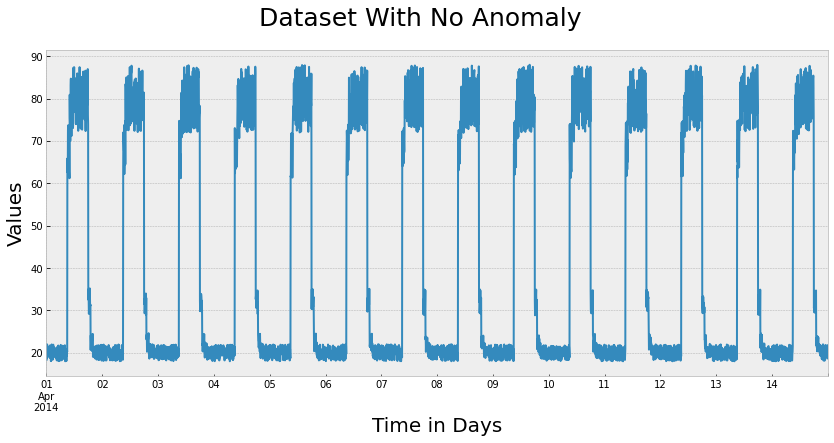

In [9]:
# Plotting as subplot, setting fig size to 14,6.
fig, ax = plt.subplots(figsize =(14,6))

# Plotting dataframe on single axis.  Legend = false as its not useful.
df_small_noise.plot(legend=False, ax=ax)

# Setting title. 
fig.suptitle('Dataset With No Anomaly ', fontsize=25)

# Setting x and y axis label. 
plt.xlabel('Time in Days', fontsize=20)
plt.ylabel('Values',fontsize=20);

The above plot shows **consistent** spikes in values each day.  We cannot see any anomaly here as the spike is consistently present for each of the 14 days.  If a spike was not present, too small or too large, this might be considered as an anomaly. 

<br>

In [10]:
# Getting statistics on the no anomaly dataset. 
df_small_noise.describe()

,value
count,4032.000000
mean,42.438353
std,28.077122
min,18.000964
25%,19.841390
50%,21.608487
75%,75.450282
max,87.976128


<br>

### Reading in file with anomaly.

In [11]:
# Reading in file with anomaly.
df_daily_jumpsup = pd.read_csv(with_anomaly_url, parse_dates=True, index_col="timestamp")

<br>

#### Previewing data with anomaly.

In [12]:
# Previewing file with anomaly. 
df_daily_jumpsup.head()

,value
timestamp,
2014-04-01 00:00:00,19.761252
2014-04-01 00:05:00,20.500833
2014-04-01 00:10:00,19.961641
2014-04-01 00:15:00,21.490266
2014-04-01 00:20:00,20.187739


<br>

#### Plotting data with anomaly.

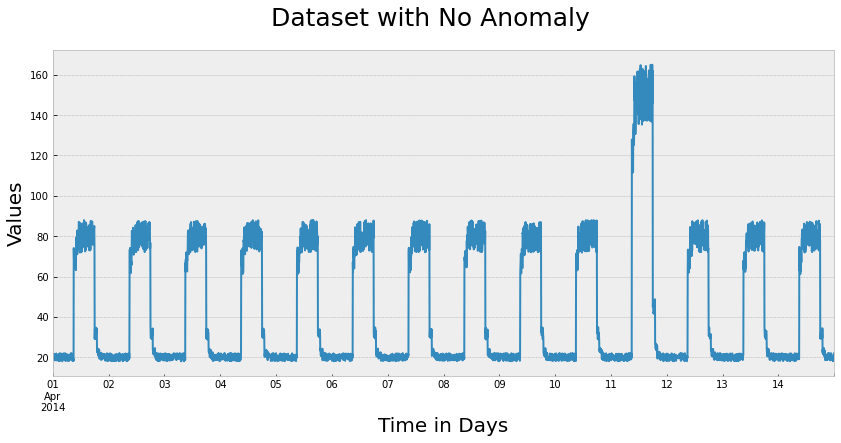

In [13]:
# Plotting as subplot, setting fig size to 14,6.
fig, ax = plt.subplots(figsize =(14,6))

# Plotting dataframe on single axis.  Legend = false as its not useful.
df_daily_jumpsup.plot(legend=False, ax=ax)

# Setting title. 
fig.suptitle('Dataset with No Anomaly', fontsize=25)

# Setting x and y axis label. 
plt.xlabel('Time in Days', fontsize=20)
plt.ylabel('Values',fontsize=20);

On the 11th April 2014 we can see a **inconsistently** large spike, double that of each other day. 

In [14]:
print(f"Max value on dataset without anomaly: {df_small_noise.max().value}")
print(f"Max value on dataset with anomaly: {df_daily_jumpsup.max().value}")

Max value on dataset without anomaly: 87.97612832639999
Max value on dataset with anomaly: 164.947480513


In [15]:
# Getting statistics on the dataset with an anomaly. 
df_daily_jumpsup.describe()

,value
count,4032.000000
mean,44.494254
std,32.432473
min,18.001010
25%,19.991382
50%,21.648503
75%,76.435943
max,164.947481


<br>

## Pre-processing

Before building a machine learning model, the dataset must be processed.  Data preprocessing involves particular steps to transform the data so that it can be easily parsed into the model.  The steps used in this workbooks for this particualr dataset are:
- Scaling
- Re-Framing

**Scaling** is carried out on the training data set in the interest of efficiently training the model.  The greater variance between numbers within a dataset, the slower the model will be at training.  Its said that when the values in the dataset have large differences the model will take more time understanding the data and accuracy can be lower [9].  This is the case with the training dataset "df_small_noise".  The minimum number we seen is 18.000 and the maximum is 87.976.  

There are two options for scaling machine learning datasets, normalisation or standardisation.   Normalisation is a techique where values are reassigned between the range of 0 and 1.  Standardisation is a techique where the values are distributed around the mean of 0, using a standard deviation [10]. The method used in this demonstration is the standardisation technique. 


**Re-Framing** is the process of restructuring time-series dataset to look like a supervised learning problem. Supervised learning is when we have an input and an output, we use an algorithm to learn the mapping from the input to the output. In the Kera algorithm, we use sliding windows over the dataset.  The previous time values are the inputs and the next time value is the output. The windows will eventually iterate through the dataset [11]. 

<br>

#### Standardising the training data set

In [16]:
# Getting the mean of the dataset. 
train_mean =  df_small_noise.mean()

# Getting the stardard deviation of the dataset.
train_std = df_small_noise.std()

In [17]:
# Calculating the training values.
df_train_vals = (df_small_noise - train_mean) / train_std

In [18]:
# Printing first 5 training values.
df_train_vals.head()

,value
timestamp,
2014-04-01 00:00:00,-0.858829
2014-04-01 00:05:00,-0.728993
2014-04-01 00:10:00,-0.848148
2014-04-01 00:15:00,-0.729586
2014-04-01 00:20:00,-0.731173


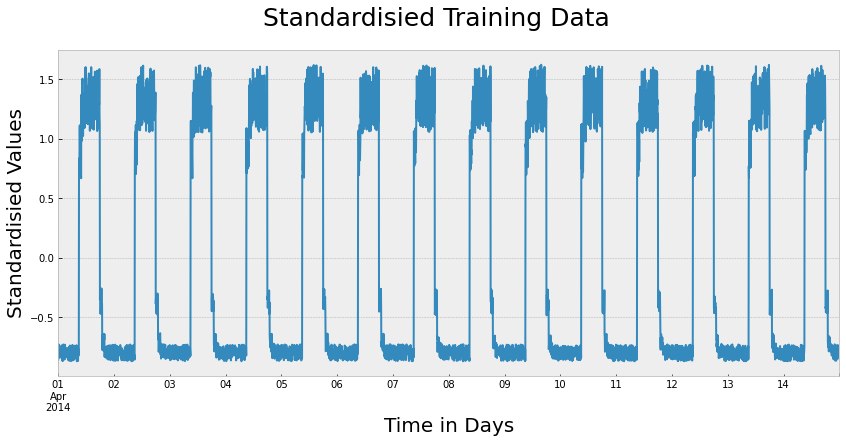

In [19]:
# Plotting as subplot, setting fig size to 14,6.
fig, ax = plt.subplots(figsize =(14,6))

# Plotting dataframe on single axis.  Legend = false as its not useful.
df_train_vals.plot(legend=False, ax=ax)

# Setting title. 
fig.suptitle('Standardisied Training Data', fontsize=25)

# Setting x and y axis label. 
plt.xlabel('Time in Days', fontsize=20)
plt.ylabel('Standardisied Values',fontsize=20);

In [20]:
# Printing the number of training samples. 
print("Number of training samples:", df_train_vals.shape[0])

Number of training samples: 4032


<br>

#### Re-framing Training Data into Sliding Windows

In [21]:
# Number values in each window is 288.
windows_size = 288

<br>

The below function creates the training sequences for the model. These are made using sliding windows through the data set. As seen above the data set consists of 4032 values. The size of each window is 288. The final window will consist of the last 288 values in the sample.  As it cannot iterate further to the right, the number of windows created will be (4032 - 288) +1.  +1 because the first window of 288 values inhibates the full interation through these values. 

We also see that the output of the function is a stacked array. This converts the list of lists into a two dimential array of the same shape [12].

In [22]:
# Creating a function that takes in an array of values and the window size.  Window size has already been assigned in the parameters. 
def windows(values, N=windows_size):
    
    # start with an empty list
    output = []
    
    # Loop through all the possible windows.
    for i in range(len(values) - N + 1):
        
        # Append each window to the list. 
        output.append(values[i : (i + N)])
    
    # Return the list as stacked arrays.
    return np.stack(output)

In [50]:
# Run the windows function.  Pass in the values in the training dataframe. 
x_train = windows(df_train_vals.values)

In [49]:
print (f"As the function iterates through the full data set of {df_train_vals.shape[0]} values, it creates {x_train.shape[0]} windows each containing {x_train.shape[1]} values.")

As the function iterates through the full data set of 4032 values, it creates 3745 windows each containing 288 values.


<br>

Below I will visualise the first window (288 values) along side the first 1200 values which is approx 4 windows. 

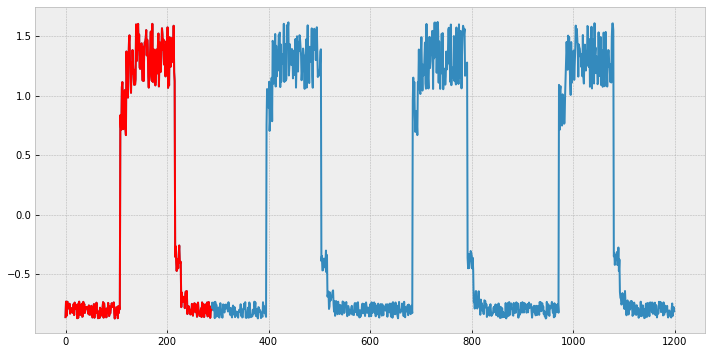

In [25]:
# Creating a plot axes size 12,6. 
fig, ax = plt.subplots(figsize =(12,6))

# Getting the first 1200 values i.e. this will be approx 4 windows. 
y = df_train_vals['value'].values[:1200]

# Plotting the first 1200 values.
ax.plot(np.arange(y.shape[0]), y, label = 'signal')

# Getting the first window in a single array.  
w = x_train[0].flatten()

# Plotting the first window in red. 
ax.plot(np.arange(w.shape[0]),w, color='r', label = 'window 1');

<br>

### Creating the Neural Network

As dicussed above a neural networks is ordered in **layers**. Each layer is activated consecutively. The Sequential function in Kera's can be used where each layer has exactly one input tensor and one output tensor. In that case each layer will carry out a particular method.  The layers being used in this model are described below. 


- **Input**: The model will take the window input of size 288 values, and release the same sequence lenght. It provides the input shape [13].

<br>

- **Conv1D**: This is a 1 dimensional convolution layer.  "*This layer creates a convolution kernel that is convoluted with the input layer over a single spatial dimension to produce a tensor of outputs.*" During this process a filter is slid (convoluted) over the input data [14].

        - The size of this sliding window is determined by the "kernel size". [14]
        - The filters will determine how many different windows we will have. [14]
        - When you use filters=100 and kernel_size=4, you are creating 100 different filters, each of them with length 4. The result will bring 100 different convolutions. 
        - The activation function determines if the output is allowed or not allowed.  The "relu" activation coverts negative elements to 0. All other elements (>0) remian unchanged [15]. 
<br>

- **Dropout**: This layer prevents overfitting. 
 
<br>

- **Conv1DTranspose**








<br>
<br>
<br>



optimizers

compling

Summary

In [26]:
# Search each method and comment on what it does. 
layers = [
    keras.layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
    keras.layers.Conv1D(filters=32, kernel_size=7, padding="same", strides=2, activation="relu"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Conv1D(filters=16, kernel_size=7, padding="same", strides=2, activation="relu"),
    keras.layers.Conv1DTranspose(filters=16, kernel_size=7, padding="same", strides=2, activation="relu"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Conv1DTranspose(filters=32, kernel_size=7, padding="same", strides=2, activation="relu"),
    keras.layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same")
]

In [27]:
# building the model. 
model = keras.Sequential(layers)
# optimizer - comment on what this is. 
optimizer=keras.optimizers.Adam(learning_rate=0.001)
# comment on compile and mse. 
model.compile(optimizer=optimizer, loss="mse")
# comment
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 144, 32)           256       
                                                                 
 dropout (Dropout)           (None, 144, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 72, 16)            3600      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 144, 16)          1808      
 nspose)                                                         
                                                                 
 dropout_1 (Dropout)         (None, 144, 16)           0         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 288, 32)          3616      
 ranspose)                                              

<br>

Fitting the model. 


Explain whats going on.

In [28]:
# sequential - model fit method - history - comment on this and parameters.
# https://www.tensorflow.org/api_docs/python/tf/keras/Sequential#fit
history = model.fit(
    x_train, # x_train was no anomaly. Used as input and output
    x_train, # He is saying that when he give this as the input, he expects it to be the output. 
    epochs=50, 
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)


Epoch 1/50
27/27 [==============================] - 2s 29ms/step - loss: 0.4201 - val_loss: 0.0522
Epoch 2/50
27/27 [==============================] - 1s 23ms/step - loss: 0.0719 - val_loss: 0.0384
Epoch 3/50
27/27 [==============================] - 1s 25ms/step - loss: 0.0563 - val_loss: 0.0346
Epoch 4/50
27/27 [==============================] - 1s 25ms/step - loss: 0.0490 - val_loss: 0.0317
Epoch 5/50
27/27 [==============================] - 1s 23ms/step - loss: 0.0436 - val_loss: 0.0283
Epoch 6/50
27/27 [==============================] - 1s 23ms/step - loss: 0.0395 - val_loss: 0.0275
Epoch 7/50
27/27 [==============================] - 1s 23ms/step - loss: 0.0357 - val_loss: 0.0273
Epoch 8/50
27/27 [==============================] - 1s 24ms/step - loss: 0.0329 - val_loss: 0.0271
Epoch 9/50
27/27 [==============================] - 1s 25ms/step - loss: 0.0305 - val_loss: 0.0268
Epoch 10/50
27/27 [==============================] - 1s 24ms/step - loss: 0.0284 - val_loss: 0.0289
Epoch 11/

<br>

### Evaluation

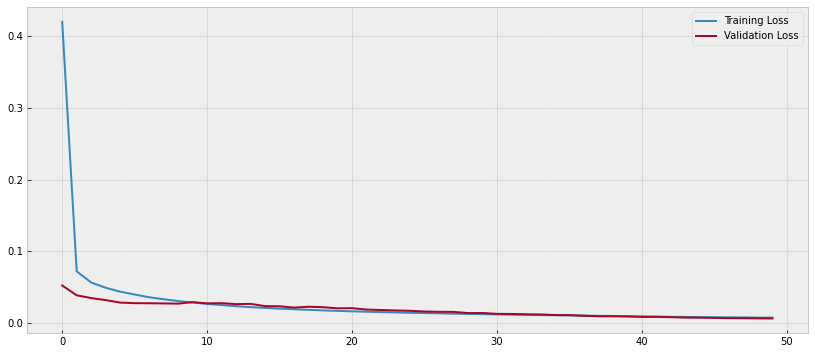

In [29]:
#
fig, ax = plt.subplots(figsize = (14,6))
#
ax.plot(history.history["loss"], label="Training Loss") # history kept because of callback above. History of how the training procedure went.  # look up loss and val_loss in keras. 
                                                                    #I think Epoch will stop early if loss stops goingw
#
ax.plot(history.history["val_loss"], label="Validation Loss")
#
ax.legend();

<br>

MAE loss what does this mean. 

In [30]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)

118/118 [==============================] - 1s 3ms/step


In [31]:
# Calculate the loss... 
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

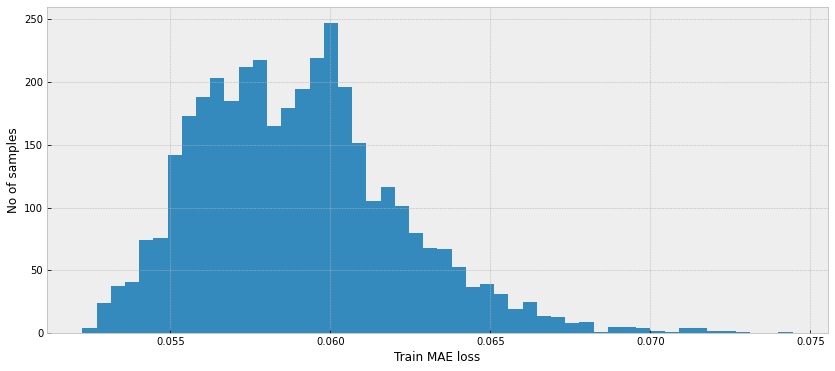

In [32]:
#
fig, ax = plt.subplots(figsize=(14,6))
#
ax.hist(train_mae_loss, bins=50)
#
ax.set_xlabel("Train MAE loss")
#
ax.set_ylabel("No of samples");

In [33]:
# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

Reconstruction error threshold:  0.07444335790215573


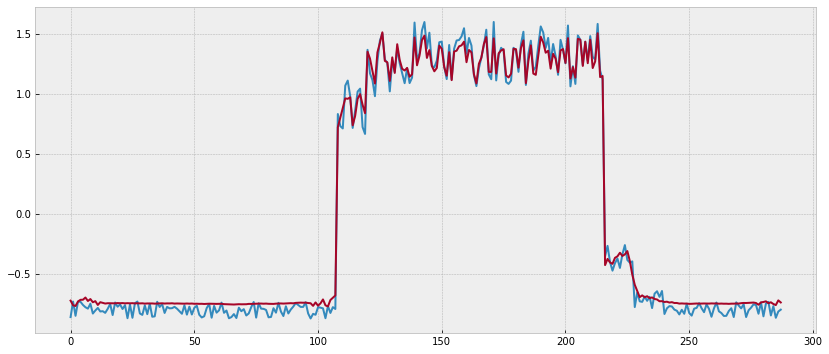

In [34]:
# Checking how the first sequence is learnt
fig, ax = plt.subplots(figsize=(14,6))
ax.plot(x_train[0])
ax.plot(x_train_pred[0]);

In [35]:
#
df_test_value = (df_daily_jumpsup - train_mean) / train_std

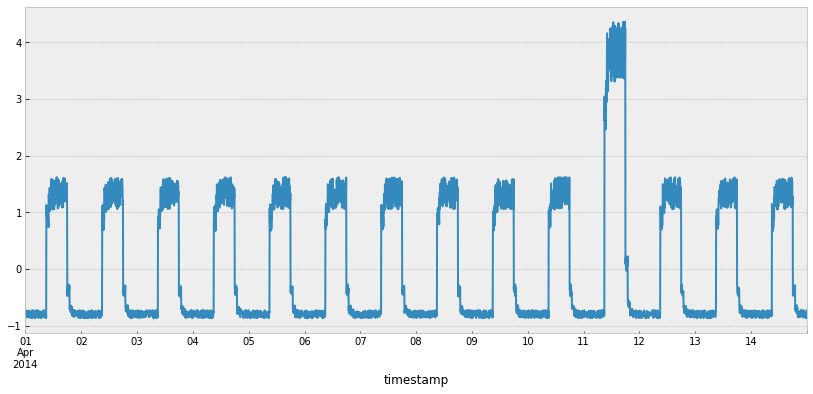

In [36]:
#
fig, ax = plt.subplots(figsize=(14,6))
#
df_test_value.plot(legend=False, ax=ax);

In [37]:
# Create sequences from test values.
x_test = windows(df_test_value.values)

#
print("Test input shape: ", x_test.shape)

Test input shape:  (3745, 288, 1)


In [38]:
# Get test MAE loss. - looked up previously
x_test_pred = model.predict(x_test)

118/118 [==============================] - 0s 3ms/step


In [39]:
#
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)

In [40]:
# Reshaped
test_mae_loss = test_mae_loss.reshape((-1))

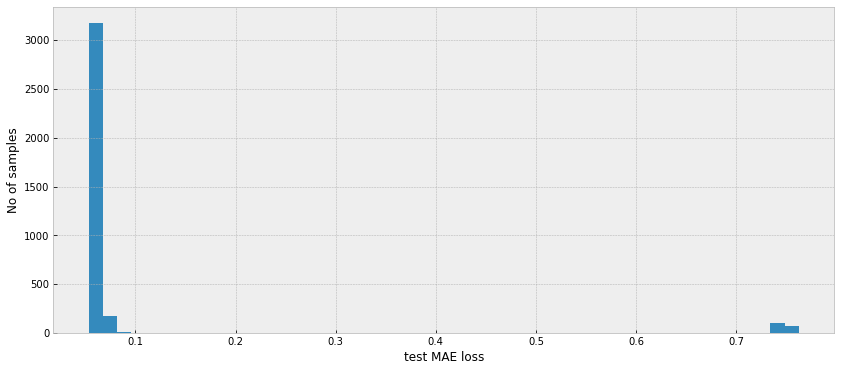

In [41]:
#
fig, ax = plt.subplots(figsize=(14,6))
#
ax.hist(test_mae_loss, bins=50)
#
ax.set_xlabel("test MAE loss")
#
ax.set_ylabel("No of samples"); 

In [42]:
# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold

# Print number of anomalies 
np.sum(anomalies)

404

In [43]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
inds = []

for i in range(windows_size - 1, len(df_test_value) - windows_size + 1):
    if np.all(anomalies[i - windows_size + 1 : i]):
        inds.append(i)

In [44]:
# 
df_subset = df_daily_jumpsup.iloc[inds]

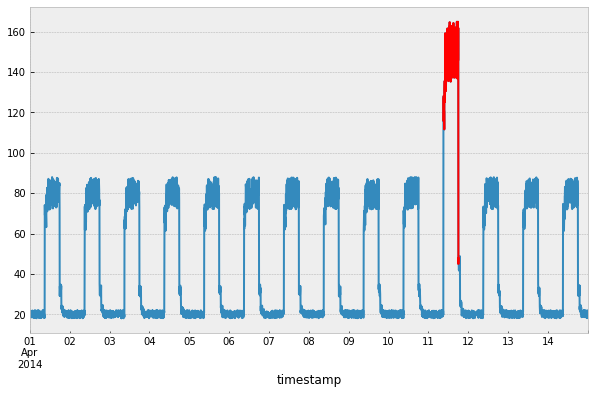

In [45]:
#
fig, ax = plt.subplots(figsize=(10,6))

#
df_daily_jumpsup.plot(legend=False, ax=ax)

#
df_subset.plot(legend=False, ax=ax, color="r"); 

## Conclusion

Suggest improvements I could make to the analysis in this workbook.

***

## References


1. https://github.com/tensorflow/tensorflow
2. https://www.infoworld.com/article/3278008/what-is-tensorflow-the-machine-learning-library-explained.html
3. https://www.guru99.com/what-is-tensorflow.html#1
4. https://www.ibm.com/topics/neural-networks
5. https://www.simplilearn.com/tutorials/deep-learning-tutorial/what-is-keras
6. https://keras.io/api/layers/
7. https://towardsdatascience.com/effective-approaches-for-time-series-anomaly-detection-9485b40077f1
8. https://www.kaggle.com/datasets/boltzmannbrain/nab
9. https://analyticsindiamag.com/why-data-scaling-is-important-in-machine-learning-how-to-effectively-do-it/
10. https://www.analyticsvidhya.com/blog/2020/04/feature-scaling-machine-learning-normalization-standardization/
11. https://machinelearningmastery.com/time-series-forecasting-supervised-learning/
12. https://sparkbyexamples.com/numpy/how-to-use-numpy-stack-in-python/
13. https://keras.io/examples/timeseries/timeseries_anomaly_detection/
14. https://kitchell.github.io/DeepLearningTutorial/4cnnsinkeras.html
15. https://towardsdatascience.com/activation-functions-neural-networks-1cbd9f8d91d6




## End
***